In [ ]:
# Need to double check the appointment times
# Comb through daily openings a couple days out, and confirm whether there
# are overlapping shifts

In [2]:
# Loading libraries
import boto3
import pandas as pd
from io import StringIO
from math import floor
import matplotlib.pyplot as plt

In [3]:
# Defining paths
myBucket = 'tcmbooking'

In [4]:
# Function which returns lists of errors, openings and shifts in s3 bucket
def get_tcm_files(bucket):
    """Get a list of keys in an S3 bucket"""
    errors = []
    openings = []
    shifts = []
    
    resp = s3.list_objects_v2(Bucket=bucket)
    for x in resp['Contents']:
        if "error" in x['Key']:
            errors.append(x['Key'])
        elif "openings" in x['Key']:
            openings.append(x['Key'])
        elif "shifts" in x['Key']:
            shifts.append(x['Key'])
        
    return errors, openings, shifts

In [5]:
# Getting list of files in s3 bucket
s3 = boto3.client('s3')
errors, openings, shifts = get_tcm_files(myBucket)

In [142]:
# Creating data frame of the openings
dailyOpenings = pd.DataFrame()

for x in openings:
    # Reading in data from s3
    csv_obj = s3.get_object(Bucket=myBucket, Key=x)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string))
    
    # Selecting only same day data
    df = df.loc[df['DaysAhead']==0]
    dailyOpenings = dailyOpenings.append(df, ignore_index=True)
    
dailyOpenings.drop_duplicates(inplace=True)

In [143]:
# Creating data frame of the shifts
dailyShifts = pd.DataFrame()

for x in shifts:
    # Reading in data from s3
    csv_obj = s3.get_object(Bucket=myBucket, Key=x)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string))
    
    # Selecting only same day data
    df = df.loc[df['DaysAhead']==0]
    dailyShifts = dailyShifts.append(df, ignore_index=True)
    
dailyShifts.drop_duplicates(inplace=True)

In [144]:
# Getting the opening time
dailyShifts['StartH'] = dailyShifts['Start'].str[:2]
dailyShifts['StartM'] = dailyShifts['Start'].str[3:]
dailyShifts['StartH'] = dailyShifts.StartH.astype(float)
dailyShifts['StartM'] = dailyShifts.StartM.astype(float)
dailyShifts['StartM'] = dailyShifts['StartM'] / 60
dailyShifts['Open']  = dailyShifts['StartH'] + dailyShifts['StartM']
dailyShifts = dailyShifts.drop(['StartH', 'StartM'], axis = 1)

In [145]:
# Getting the closing time
dailyShifts['CloseH'] = dailyShifts['End'].str[:2]
dailyShifts['CloseM'] = dailyShifts['End'].str[3:]
dailyShifts['CloseH'] = dailyShifts.CloseH.astype(float)
dailyShifts['CloseM'] = dailyShifts.CloseM.astype(float)
dailyShifts['CloseM'] = dailyShifts['CloseM'] / 60
dailyShifts['Close']  = dailyShifts['CloseH'] + dailyShifts['CloseM']
dailyShifts = dailyShifts.drop(['CloseH', 'CloseM'], axis = 1)

In [146]:
# Getting the open hours per day
openHours = dailyShifts.groupby(['URL', 'Date'], as_index=False).agg({"Open":"min", "Close":"max"})
openHours['maxHours'] = (openHours['Close'] - openHours['Open'])*60
openHours = openHours.drop(['Open', 'Close'], axis = 1)

In [147]:
# Joining max hours to the daily shifts data frame
print('Number of rows pre-merge: ' + str(dailyShifts.shape[0]))
dailyShifts = dailyShifts.merge(openHours, on = ['URL', 'Date'], how='left', right_index=False)
print('Number of rows pre-merge: ' + str(dailyShifts.shape[0]))

Number of rows pre-merge: 658
Number of rows pre-merge: 658


In [148]:
# Function to choose the shift duration to be used in future calculations
def getHours(row):
    if row['Duration'] > row['maxHours']:
        val = row['maxHours']
    else:
        val = row['Duration']
        
    return val

In [149]:
dailyShifts['WorkTime'] = dailyShifts.apply(getHours, axis = 1)

In [150]:
# Aggregating shifts and openings
shifts_agg = dailyShifts.groupby(['Clinician', 'Date'], as_index=False).agg({"URL": "first", "WorkTime": "sum"})
openings_agg = dailyOpenings.groupby(['Clinician', 'Date'], as_index=False).agg({"URL": "first", "Duration": "sum", "DaysAhead": "count"})

# Renaming columns to eliminate duplicates
shifts_agg.columns = ['Clinician', 'Date', 'URL', 'ShiftTime']
openings_agg.columns = ['Clinician', 'Date', 'URL', 'OpenTime', 'OpenSlots']

In [151]:
# Merging shifts and openings data frames
print('Number of rows pre-merge: ' + str(shifts_agg.shape[0]))
daily = shifts_agg.merge(openings_agg, on = ['Clinician', 'URL', 'Date'], how='left', right_index=False)
daily['OpenTime'] = daily['OpenTime'].fillna(0)
daily['OpenSlots'] = daily['OpenSlots'].fillna(0)
print('Number of rows post-merge: ' + str(daily.shape[0]))

Number of rows pre-merge: 421
Number of rows post-merge: 421


In [152]:
# Getting price data
prices = pd.read_csv('/home/ubuntu/getTCM/jane_url.csv')
prices.columns = ['Clinic', 'Clinician', 'URL', 'Location', 'Cost', 'ApTime', 'Area']
prices['ApTime'] = prices['ApTime'].fillna(60)
prices = prices.drop(['Clinician'], axis=1)

In [153]:
# Joining data frames
daily = daily.merge(prices, on = 'URL', how='left', right_index=False)
daily.drop_duplicates(inplace=True)
print('Number of rows post-merge: ', str(daily.shape[0]))

Number of rows post-merge:  421


In [154]:
# Joining data frames
daily = daily.merge(openHours, on = ['URL', 'Date'], how='left', right_index=False)
daily.drop_duplicates(inplace=True)
print('Number of rows post-merge: ', str(daily.shape[0]))

Number of rows post-merge:  421


In [155]:
daily['Duration'] = daily['ShiftTime']
daily['ShiftTime'] = daily.apply(getHours, axis = 1)
daily = daily.drop(['Duration', 'maxHours'], axis=1)

In [156]:
# Estimating revenue
daily['AllSlots'] = daily['ShiftTime'] / daily['ApTime']
daily = daily.round({'Bookings': 0})

daily['AllSlots'] = daily['ShiftTime'] / daily['ApTime']
daily['AllSlots'] = daily.AllSlots.apply(floor)
daily['BookedSlots'] = daily['AllSlots'] - daily['OpenSlots']
daily['DailyRevenue'] = daily['BookedSlots'] * daily['Cost']

In [157]:
# Calculating week number
daily['Week'] = pd.to_datetime(daily['Date'])
daily['Week'] = daily['Week'].dt.week

In [160]:
# Aggregating shifts and openings
weekly_agg = daily.groupby(['Week', 'Area'], as_index=False).agg({"Date": "first", "AllSlots": "sum", "BookedSlots":"sum", "DailyRevenue":"sum", "ShiftTime":"sum", "Clinician": pd.Series.nunique})
weekly_agg['FillRate'] = weekly_agg['BookedSlots']/weekly_agg['AllSlots']
weekly_agg['FillRate'] =100*weekly_agg['FillRate']
weekly_agg['FillRate'] = weekly_agg.FillRate.apply(floor)
weekly_agg['ShiftTime'] = round(weekly_agg['ShiftTime'] / 60, 1)
weekly_agg['AvgRevenue'] = weekly_agg['DailyRevenue'] / weekly_agg['Clinician']
weekly_agg['AvgRevenue'] = weekly_agg.AvgRevenue.apply(floor)
weekly_agg['HrRevenue'] = round(weekly_agg['DailyRevenue'] / weekly_agg['ShiftTime'],0)
weekly_agg.columns = ['Week', 'Area', 'Date', 'AllSlots', 'BookedSlots','WeeklyRevenue','WeeklyHrs', 'nPractitioner', 'FillRate', 'AvgRevenue', 'RevPerHr']

In [161]:
# Creating industry averages
industry_agg = daily.groupby(['Week'], as_index=False).agg({"Date": "first", "AllSlots": "sum", "BookedSlots":"sum", "DailyRevenue":"sum", "ShiftTime":"sum", "Clinician": pd.Series.nunique})
industry_agg['FillRate'] = industry_agg['BookedSlots']/industry_agg['AllSlots']
industry_agg['FillRate'] =100*industry_agg['FillRate']
industry_agg['FillRate'] = industry_agg.FillRate.apply(floor)
industry_agg['ShiftTime'] = round(industry_agg['ShiftTime'] / 60, 1)
industry_agg['AvgRevenue'] = industry_agg['DailyRevenue'] / industry_agg['Clinician']
industry_agg['AvgRevenue'] = industry_agg.AvgRevenue.apply(floor)
industry_agg['HrRevenue'] = round(industry_agg['DailyRevenue'] / industry_agg['ShiftTime'],0)
industry_agg.columns = ['Week', 'Date', 'AllSlots', 'BookedSlots','WeeklyRevenue','WeeklyHrs', 'nPractitioner', 'FillRate', 'AvgRevenue', 'RevPerHr']
industry_agg['Area'] = 'All'
industry_agg = industry_agg[['Week', 'Area', 'Date', 'AllSlots', 'BookedSlots','WeeklyRevenue','WeeklyHrs', 'nPractitioner', 'FillRate', 'AvgRevenue', 'RevPerHr']]

In [162]:
# Appending aggregated data frames
weekly_agg = weekly_agg.append(industry_agg, ignore_index = True)

In [163]:
# Function to choose the shift duration to be used in future calculations
def getStartOfWeek(weekNo):
    x = datetime.datetime.strptime('2019-W' + str(weekNo) + '-1', '%Y-W%W-%w').strftime('%Y-%m-%d')
    return x

In [164]:
weekly_agg['Date'] = weekly_agg.Week.apply(getStartOfWeek)
weekly_agg = weekly_agg[weekly_agg['Week']>9]

In [165]:
# Creating pivoted data frames
fill_pivot = weekly_agg.drop(['Week', 'AllSlots','BookedSlots','WeeklyRevenue', 'nPractitioner', 'AvgRevenue'], axis=1).pivot(index="Date", columns = "Area", values = "FillRate")
fill_pivot = fill_pivot.reset_index()

revenue_pivot = weekly_agg.drop(['Week', 'AllSlots','BookedSlots','WeeklyRevenue', 'nPractitioner', 'FillRate'], axis=1).pivot(index="Date", columns = "Area", values = "RevPerHr")
revenue_pivot = revenue_pivot.reset_index()

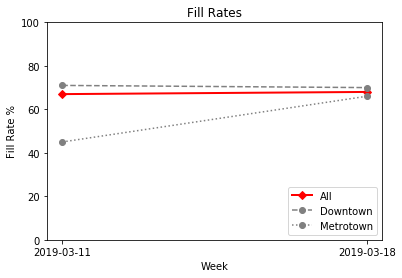

In [166]:
# Plotting fill rates
labels = ['All', 'Downtown', 'Metrotown']
line_chart1 = plt.plot(fill_pivot.Date, fill_pivot.All, marker="D", linewidth = 2, color = 'r')
line_chart1 = plt.plot(fill_pivot.Date, fill_pivot.Downtown, marker="o", color = 'grey', label = 'Downtown', linestyle = '--')
line_chart1 = plt.plot(fill_pivot.Date, fill_pivot.Metrotown, marker="o", color = 'grey', linestyle = ':')
plt.title('Fill Rates')
plt.xlabel('Week')
plt.ylabel('Fill Rate %')
plt.ylim(0, 100)
plt.legend(labels, loc=4)
plt.show()

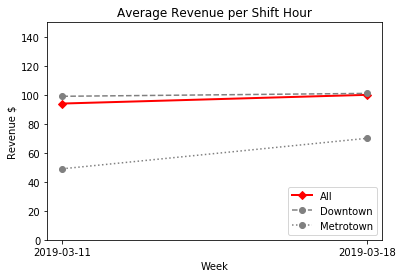

In [167]:
# Plotting fill rates
line_chart1 = plt.plot(fill_pivot.Date, revenue_pivot.All, marker="D", linewidth = 2, color = 'r')
line_chart1 = plt.plot(revenue_pivot.Date, revenue_pivot.Downtown, marker="o", color = 'grey', linestyle = '--')
line_chart1 = plt.plot(revenue_pivot.Date, revenue_pivot.Metrotown, marker="o", color = 'grey', linestyle = ':')
plt.title('Average Revenue per Shift Hour')
plt.xlabel('Week')
plt.ylabel('Revenue $')
plt.ylim(0, 150)
plt.legend(['All', 'Downtown', 'Metrotown'], loc=4)
plt.show()

In [194]:
# Aggregating revenue by clinician
clinician_agg = daily.groupby(['Week', 'Clinician'], as_index=False).agg({"DailyRevenue":"sum", "ShiftTime":"sum", "BookedSlots":"sum", "AllSlots":"sum"})
clinician_agg = clinician_agg.sort_values(by=['Week', 'DailyRevenue'], ascending=[1,0])
clinician_agg.reset_index(inplace=True, drop = True)

In [195]:
# Creating KPIs
clinician_agg['RevPerHour'] = 60 * (clinician_agg['DailyRevenue'] / clinician_agg['ShiftTime'])
clinician_agg['RevPerHour'] = clinician_agg.RevPerHour.apply(floor)
clinician_agg['FillRate'] = 100*round(clinician_agg['BookedSlots']/clinician_agg['AllSlots'], 2)
clinician_agg = clinician_agg.drop(['ShiftTime', 'BookedSlots', 'AllSlots'], axis=1)

In [196]:
# Creating ranks
clinician_agg['Rank'] = 1
w0 = clinician_agg.Week[0]
for index, row in clinician_agg.iterrows():
        w1 = row.Week
        if ((w1 == w0) & (index != 0)):
            clinician_agg.Rank[index] = clinician_agg.Rank[index-1] + 1
        w0 = w1

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [202]:
# Creating top ten list
this_week = clinician_agg[clinician_agg['Week'] == clinician_agg.Week.max()]
last_week = clinician_agg[clinician_agg['Week'] == (clinician_agg.Week.max() - 1)]
last_week = last_week.drop(['Week', 'DailyRevenue','RevPerHour','FillRate'], axis = 1)
this_week = this_week.drop('Week', axis = 1)
last_week.columns = ['Clinician', 'LastWeek']
this_week.columns = ['Clinician', 'Revenue', 'RevPerHour', 'FillRate', 'ThisWeek']
this_week = this_week.merge(last_week, on = ['Clinician'], how='left', right_index = False)
this_week['Revenue'] = this_week['Revenue'].apply(floor)

In [204]:
this_week.head(n=10)

,Clinician,Revenue,RevPerHour,FillRate,ThisWeek,LastWeek
0,Dr. Byoung Jin NA,6160,194,90.0,1,1
1,Dr. Ryan Funk,4940,161,85.0,2,4
2,Bronwyn Melville,4750,163,86.0,3,6
3,Kathleen Lee,4180,154,81.0,4,10
4,Kelli Taylor,3990,204,100.0,5,7
5,Dr. Jie (Janet) Yu,3835,95,74.0,6,3
6,Tedi Fisher,3808,224,100.0,7,16
7,Hoon il (Melanie) Kwak,3600,200,100.0,8,2
8,Allison Locke,3515,156,82.0,9,11
9,Dr. Brad Matthews,3420,150,84.0,10,9


In [210]:
# Calculating KPIs
capacity = round(pd.Series(daily['AllSlots']).sum(),0)
bookings = round(pd.Series(daily['BookedSlots']).sum(),0)
fillRate = 100*round(bookings/capacity,3)
revenue = pd.Series(daily['DailyRevenue']).sum()
nPractitioner = len(daily.Clinician.unique())
avgRevenue = round(revenue / nPractitioner, 0)
print("Capacity: " + "{:.0f}".format(capacity))
print("Bookings: " + "{:.0f}".format(bookings))
print("Fill Rate: " + "{:.1f}".format(fillRate) + "%")
print("Avg Revenue: $" + "{:.0f}".format(avgRevenue))

Capacity: 4282
Bookings: 2938
Fill Rate: 68.6%
Avg Revenue: $3683
